# 캐글 제공 타이타닉 탑승자 데이터 기반

1) 캐글 데이터(https://www.kaggle.com/c/titanic/data) 다운로드

In [1]:
# Miscellaneous operating system interfaces
import os

# The fundamental package for scientific computing with Python.
import numpy as np

# Flexible and powerful data analysis / manipulation library for Python, providing labeled data structures similar to R data.frame objects, statistical functions, and much more
import pandas as pd

# Set the absolute directory path.
BASE_PATH = os.path.abspath('')
APP_PATH = os.path.dirname(BASE_PATH)
DATA_PATH = os.path.join(APP_PATH, '00.data')

In [2]:
# Statistical data visualization using matplotlib.
import seaborn as sns

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Set the matplotlib color cycle using a seaborn palette.
sns.set_palette('pastel')

# plot outputs appear and be stored within the notebook.
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

mpl.rc('axes', unicode_minus=False)

if sys.platform.startswith('darwin'):
    mpl.rc('font', family='AppleGothic')
elif sys.platform.startswith('win32'):
    mpl.rc('font', family='Malgun Gothic')

Matplotlib is building the font cache; this may take a moment.


## 2) 데이터 확인

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, 'kaggle.com', 'titanic', 'train.csv'))

# 3) 결손치 처리
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Cabin'].fillna('-', inplace=True)
df['Embarked'].fillna('-', inplace=True)

# 4) 문자열 처리
df['Cabin'] = df['Cabin'].str[:1]

# Null값 체크
print('Null: {}'.format(df.isnull().sum().sum()))

df.head(1)

Null: 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,-,S


## 5) Survived 속성을 y로 나머지 피쳐를 X로 만듦

In [4]:
df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

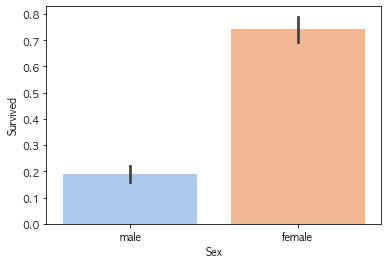

In [5]:
sns.barplot(x='Sex', y='Survived', data=df)

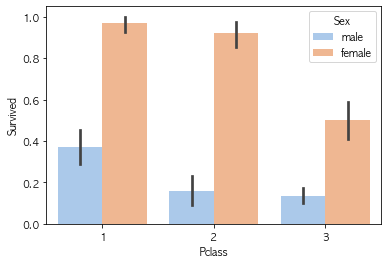

In [6]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df);

In [7]:
# 나이 구분에 따른 카테고리 설정
bins = [-1, 5, 12, 19, 29, 60, 100]
labels = ['Baby', 'Child', 'Teenager', 'Youth', 'Adult', 'Elderly']

df['Cat'] = pd.cut(df['Age'], bins, labels=labels)

<AxesSubplot:xlabel='Cat', ylabel='Survived'>

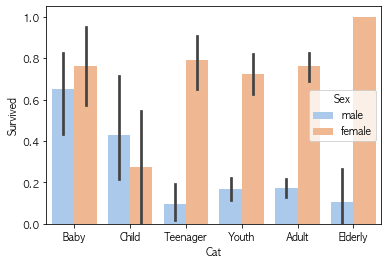

In [8]:
sns.barplot(x='Cat', y = 'Survived', hue='Sex', data=df)

## 6) 학습/테스트 데이터 세트 분리

In [9]:
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder

for feature in ['Cabin', 'Sex', 'Embarked']:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,3,Youth
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,3,1,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,3,Youth
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,3,3,Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,3,Adult


In [10]:
# 데이터 전처리에 필요한 함수

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('-', inplace=True)
    df['Embarked'].fillna('-', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [11]:
# 생존자 예측 수행
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
df = pd.read_csv(os.path.join(DATA_PATH, 'kaggle.com', 'titanic', 'train.csv'))

y_axis = df['Survived']

x_axis = df.drop('Survived', axis=1)
x_axis = transform_features(x_axis)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(
    x_axis, y_axis, test_size=0.2, random_state=11
)

## 7) 적용할 알고리즘 선정:
- 결정 트리 – DecisionTreeClassifier
- 랜덤 포레스트 – RandomForestClassifier
- 로지스틱 회귀 – LogisticRegression

## 8) 학습,예측및평가

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# DecisionTreeClassifier 학습/예측/평가
dt_clf = DecisionTreeClassifier(random_state=11)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# RandomForestClassifier 학습/예측/평가
rf_clf = RandomForestClassifier(random_state=11)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# LogisticRegression 학습/예측/평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# SupportVectorClassifier 학습/예측/평가
sv_clf = SVC(random_state=11)
sv_clf.fit(X_train, y_train)
sv_pred = sv_clf.predict(X_test)

In [14]:
for func in ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC']:
    clf = globals()[func](random_state=11)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    funcname = 'SupportVectorClassifier' if func == 'SVC' else func
    print('{0} 정확도: {1:.4f}'.format(funcname, accuracy_score(y_test, pred)))

DecisionTreeClassifier 정확도: 0.7989
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8827
SupportVectorClassifier 정확도: 0.7207


## 9) 교차 검증

In [15]:
# Stratified K-Fold 방식으로 교차 검증하는 함수
from sklearn.model_selection import StratifiedKFold

def exec_skfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    skfold = StratifiedKFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count, (train_index, test_index) in enumerate(skfold.split(x_axis, y_axis)):

        # x_axis 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = x_axis.values[train_index], x_axis.values[test_index]
        y_train, y_test = y_axis.values[train_index], y_axis.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        scores.append(accuracy)
        print("교차 검증 {0}, 정확도: {1:.4f}".format(iter_count, accuracy))
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {:.4f}".format(mean_score))

In [16]:
for func in ['DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC']:
    clf = globals()[func](random_state=11)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    funcname = 'SupportVectorClassifier' if func == 'SVC' else func
    print('\n{} 모델 교차 검증'.format(funcname))
    exec_skfold(clf, folds=5)


DecisionTreeClassifier 모델 교차 검증
교차 검증 0, 정확도: 0.7542
교차 검증 1, 정확도: 0.7472
교차 검증 2, 정확도: 0.8034
교차 검증 3, 정확도: 0.7416
교차 검증 4, 정확도: 0.8202
평균 정확도: 0.7733

RandomForestClassifier 모델 교차 검증
교차 검증 0, 정확도: 0.7709
교차 검증 1, 정확도: 0.7865
교차 검증 2, 정확도: 0.8427
교차 검증 3, 정확도: 0.7697
교차 검증 4, 정확도: 0.8764
평균 정확도: 0.8092

LogisticRegression 모델 교차 검증
교차 검증 0, 정확도: 0.8045
교차 검증 1, 정확도: 0.7978
교차 검증 2, 정확도: 0.7978
교차 검증 3, 정확도: 0.7921
교차 검증 4, 정확도: 0.8258
평균 정확도: 0.8036

SupportVectorClassifier 모델 교차 검증
교차 검증 0, 정확도: 0.5922
교차 검증 1, 정확도: 0.7135
교차 검증 2, 정확도: 0.6854
교차 검증 3, 정확도: 0.6854
교차 검증 4, 정확도: 0.6910
평균 정확도: 0.6735


In [17]:
# 결정 트리 모델을 cross_val_score 함수를 이용하여 교차 검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, x_axis, y_axis, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0}, 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {:.4f}".format(np.mean(scores)))

교차 검증 0, 정확도: 0.7542
교차 검증 1, 정확도: 0.7472
교차 검증 2, 정확도: 0.8034
교차 검증 3, 정확도: 0.7416
교차 검증 4, 정확도: 0.8202
평균 정확도: 0.7733


In [18]:
# 결정 트리 모델을 cross_val_score 함수를 이용하여 교차 검증
from sklearn.model_selection import cross_val_score

for dclf in ['dt_clf', 'rf_clf', 'lr_clf', 'sv_clf']:
    print('\n{} 모델 교차 검증'.format(dclf))
    
    clf = globals()[dclf]
    scores = cross_val_score(clf, x_axis, y_axis, cv=5)

    for iter_count, accuracy in enumerate(scores):
        print("교차 검증 {0}, 정확도: {1:.4f}".format(iter_count, accuracy))

    print("평균 정확도: {:.4f}".format(np.mean(scores)))


dt_clf 모델 교차 검증
교차 검증 0, 정확도: 0.7542
교차 검증 1, 정확도: 0.7472
교차 검증 2, 정확도: 0.8034
교차 검증 3, 정확도: 0.7416
교차 검증 4, 정확도: 0.8202
평균 정확도: 0.7733

rf_clf 모델 교차 검증
교차 검증 0, 정확도: 0.7709
교차 검증 1, 정확도: 0.7865
교차 검증 2, 정확도: 0.8427
교차 검증 3, 정확도: 0.7697
교차 검증 4, 정확도: 0.8764
평균 정확도: 0.8092

lr_clf 모델 교차 검증
교차 검증 0, 정확도: 0.8045
교차 검증 1, 정확도: 0.7978
교차 검증 2, 정확도: 0.7978
교차 검증 3, 정확도: 0.7921
교차 검증 4, 정확도: 0.8258
평균 정확도: 0.8036

sv_clf 모델 교차 검증
교차 검증 0, 정확도: 0.5922
교차 검증 1, 정확도: 0.7135
교차 검증 2, 정확도: 0.6854
교차 검증 3, 정확도: 0.6854
교차 검증 4, 정확도: 0.6910
평균 정확도: 0.6735


## 10) GridSearchCV를 통해 최적 파라미터 도출

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth':[2,3,5,10],
    'min_samples_leaf':[1,5,8],
    'min_samples_split':[2,3,5] 
}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
pred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8048
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


In [20]:
from sklearn.model_selection import GridSearchCV

for dclf in ['dt_clf', 'rf_clf', 'lr_clf', 'sv_clf']:
    try:
        print('\n{}'.format(dclf))
        parameters = {
            'max_depth':[2,3,5,10],
            'min_samples_leaf':[1,5,8],
            'min_samples_split':[2,3,5] 
        }
        grid_dclf = GridSearchCV(globals()[dclf], param_grid=parameters, scoring='accuracy', cv=5)
        grid_dclf.fit(X_train, y_train)

        print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
        print('GridSearchCV 최고 정확도: {:.4f}'.format(grid_dclf.best_score_))
        best_dclf = grid_dclf.best_estimator_

        # GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
        pred = best_dclf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        print('테스트 세트에서의 DecisionTreeClassifier 정확도: {:.4f}'.format(accuracy))
    except Exception as e:
        print(dclf, e)


dt_clf
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8048
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715

rf_clf
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
GridSearchCV 최고 정확도: 0.8175
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8547

lr_clf
lr_clf Invalid parameter max_depth for estimator LogisticRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

sv_clf
sv_clf Invalid parameter max_depth for estimator SVC(random_state=11). Check the list of available parameters with `estimator.get_params().keys()`.
